## Morpheo baseline project
# Introduction to sleep scoring - Normalization methods (answers)
[Colaboratory version](https://colab.research.google.com/drive/1WvblQqLAEgWMzlH5rsPUipbJ5APXHgXV)

Please execute the cell bellow to initialize the notebook environment

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

fig_w, fig_h = (4.5, 3.5)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

Please execute the cell bellow to download the dataset.

In [ ]:
!rm -rf datasets intro-sleep-scoring
!if [ ! -d datasets ]; then git clone https://github.com/mpbrigham/intro-sleep-scoring; \
                            cp -rf ./intro-sleep-scoring/* ./; fi
  
import sleep_utils

## Import dataset
Import the dataset into dictionary `dataset` with keys `channels` and `hypnogram` for PSG and hypnogram data, respectively. The PSG data is stored with shape `(epochs, channels, samples)`. 

**Suggestions**
* Open HDF5 database `mesa_sleep_0001_s.h5`
* Print table names and shapes

**Refs**
* h5py: HDF5 for Python (http://docs.h5py.org/en/latest)

In [7]:
import sleep_utils
import importlib
importlib.reload(sleep_utils)

path = './datasets/mesa_small'
channels_ref = ['EEG1', 'EEG2', 'EEG3']

dataset = sleep_utils.load_dataset(path, channels_ref=channels_ref)

processing 6 records in folder ./datasets/mesa_small 

mesa_sleep_0014_s
mesa_sleep_0002_s
mesa_sleep_0006_s
mesa_sleep_0021_s
mesa_sleep_0001_s
mesa_sleep_0016_s

Imported 6 records


**EXPECTED OUTPUT**
```
processing 6 records in folder ./datasets/mesa_small 

mesa_sleep_0021_s
mesa_sleep_0016_s
mesa_sleep_0014_s
mesa_sleep_0006_s
mesa_sleep_0002_s
mesa_sleep_0001_s

Imported 6 records
```

## Data pre-processing

### Plot histogram of EEG channels
Plot histogram of individual EEG channels in dataset.

**Suggestions**
* Use function `np.linspace()` from Numpy to define array `x_bins` with 100 values from -0.2 to 0.2.
* Use function `plt.hist()` from Matplotlib to plot histogram of array `x`, using keyword `bins` to set bins location to `x_bins`

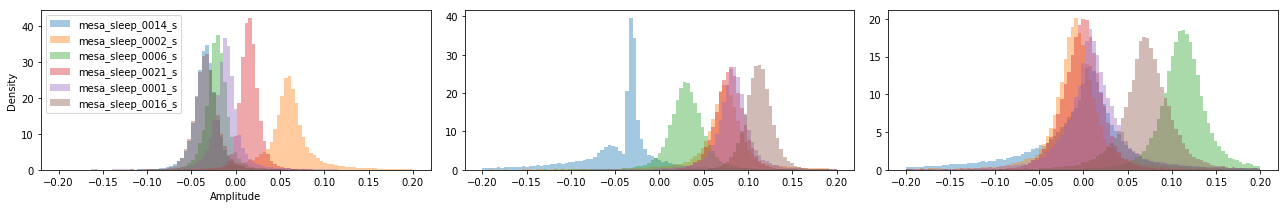

In [12]:
import sleep_utils
import importlib
importlib.reload(sleep_utils)

sleep_utils.plot_stats(dataset, x_min=-0.2, x_max=0.2)

**EXPECTED OUTPUT**

<img src="https://github.com/mpbrigham/colaboratory-figures/raw/master/sleep-scoring/eeg-histogram-pre.pn" style="height: 350px;float: left;">

### Center and scale EEG data
Write function `pre_process()` to remove channel mean and scale channels to one standard deviation or 50th absolute percentile.

Apply function to channel data and plot histograms.

In [ ]:
def pre_process(x, scale='std'):
  """Remove channel mean from array x and scale to one standard deviation or 
  absolute 50th percentile.
  x: array with shape (batch, channel, data)
  scale: 'std' | 'pct'

  returns x_out:  zero channel mean and scaled array x
  """

  x_out = x
  
  for idx in range(x.shape[1]):
    
      x_out[:,idx] = x[:,idx] - np.mean(x[:,idx], keepdims=True)

      if scale=='std':
          alpha = np.std(x_out[:,idx], keepdims=True)

      elif scale=='pct':
          alpha = np.percentile(np.abs(x_out[:,idx]), 50, keepdims=True)*10
          
      x_out[:,idx] = x_out[:,idx]/alpha
      
  return x_out

In [ ]:
dataset_std = {item: dataset[item] for item in dataset}

for key_idx, key in enumerate(dataset):
  
    dataset_std[key]['samples'] = pre_process(dataset_std[key]['samples'],
                                          scale='std')
  
sleep_utils.plot_stats(dataset_std, channels)

In [ ]:
dataset_pct = {item: dataset[item] for item in dataset}

for key_idx, key in enumerate(dataset):
  
    dataset_pct[key]['samples'] = pre_process(dataset_pct[key]['samples'],
                                          scale='pct')
  
sleep_utils.plot_stats(dataset_pct, channels)

## Prepare data for training

### Write data import function
Write function `load_data()` to import EEG channels and hypnogram from HDF5 database.

In [ ]:
def load_data(path):
  """Import EEG channels and hypnogram from HDF5 database.
  path: filesysWrite function `load_data()` to import EEG channels and hypnogram from HDF5 database.Write function `load_data()` to import EEG channels and hypnogram from HDF5 database.tem path of HDF5 database

  returns x: array containing EEG channels
          y: array containing hypnogram
  """

  # insert your code here
  x = None
  y = None

  return (x, y)

In [ ]:
def load_data(path):
  """Import EEG channels and hypnogram from HDF5 database.
  path: filesystem path of HDF5 database

  returns x: array containing EEG channels
          y: array containing hypnogram
  """

  with h5py.File(path, 'r') as f:
    x = np.stack((f['EEG1'][::], f['EEG2'][::], f['EEG3'][::]), axis=1)
    y = np.array([f['stages'][::]]).T

  return (x, y)

In [ ]:
path = 'colaboratory-data/mesa-small/mesa-sleep-0002_s.h5'

x, y = load_data(path)

x = pre_process(x)

if x is not None:
  print(x[:2])
  print(y[:2])

**EXPECTED OUTPUT**
```
[[[ 0.04396349  0.07795955  0.07226041 ...  0.04176991  0.03708698  0.04716769]
  [-0.07195704 -0.11975361 -0.10864799 ... -0.09606183 -0.09113557  -0.092215  ]
  [ 0.02422285  0.05473021  0.05198389 ...  0.01406217  0.0240755   0.0294412 ]]

 [[ 0.03657643  0.04430808  0.03648227 ...  0.03918483  0.04145856  0.04325664]
  [-0.05006481 -0.0881365  -0.07769687 ... -0.07160157 -0.05522351  -0.06842058]
  [ 0.03790487  0.05567357  0.05256429 ...  0.0541604   0.04131374  0.06555403]]]
[[0]
 [0]]
```

### Import test set
Import test set from HDF5 database `mesa-sleep-0021_s` into arrays `x_test` and `y_test`.

Print shapes of the new arrays, and basic EEG stats from array `x_test`.

In [ ]:
path = 'colaboratory-data/mesa-small/mesa-sleep-0021_s.h5'

x_test, y_test = load_data(path)

x_test = pre_process(x_test)

# insert your code here

In [ ]:
path = 'colaboratory-data/mesa-small/mesa-sleep-0021_s.h5'

x_test, y_test = load_data(path)

x_test = pre_process(x_test)

print('var\t\t shape\n')
for item, item_name in ([[x_test, 'x_test'], [y_test, 'y_test']]):
  print(item_name, '\t', item.shape)
    
print()
print_stats(x_test)

**EXPECTED OUTPUT**
```
var		 shape

x_test 	 (1079, 3, 1920)
y_test 	 (1079, 1)

EEG	 min		 max		 mean		 std

0 	 -1.9979 	 0.6084 	 0.0000 	 0.0222
1 	 -0.4698 	 2.0072 	 0.0000 	 0.0380
2 	 -5.0036 	 1.0731 	 0.0000 	 0.0511
 ```

### Split dataset into train and validation sets
Split arrays `x` and `y` into train and validation sets `x_train`, `x_val`, `y_train` and `y_val`. The validation set contains 300 epochs from each HDF5 database.

Print the shapes of the new arrays.

**Note:** the function `np.random.seed(0)` from Numpy is used to replicate the expected output.

**Suggestions**
* Create boolean array `bool_idx` with 1439 elements initialized with `False` values
* Use function `np.random.choice()` to randomly select (without replacement) 300 elements of array `bool_idx` and set them to `True`
* Split `x` into `x_train` and `x_val` using indexes from array `bool_idx`
* Use function `np.random.seed(0)` from Numpy to replicate the expected output

In [ ]:
np.random.seed(0)

x_val = None
y_val = None
x_train = None
y_train = None

# insert your code here

In [ ]:
np.random.seed(0)

bool_idx = np.array([False]*y.shape[0])
selected = np.random.choice(len(bool_idx), size=300, replace=False)
bool_idx[selected] = True

x_val = x[bool_idx]
y_val = y[bool_idx]
x_train = x[~bool_idx]
y_train = y[~bool_idx]

print('var\t\t shape\n')
for item, item_name in [[x, 'x      '], [y, 'y      '],
                        [x_train, 'x_train'], [y_train, 'y_train'],
                        [x_val, 'x_val  '], [y_val, 'y_val  ']]:
  print(item_name, '\t', item.shape)

**EXPECTED OUTPUT**
```
var		 shape

x       	 (1319, 3, 1920)
y       	 (1319, 1)
x_train 	 (1019, 3, 1920)
y_train 	 (1019, 1)
x_val   	 (300, 3, 1920)
y_val   	 (300, 1)
```

### Check train and validation sets are mutually exclusive
Execute the following code to validate that `x_val` contains no elements from `x_train`.

In [ ]:
for item_train in x_train:
  for item_val in x_val:
    assert not np.allclose(item_train, item_val), 'Failed.'
      
print('Passed.')

**EXPECTED OUTPUT**
```
Passed.
```

### Generate train and validation sets
Create train and validation sets in arrays `x_train`, `y_train`, `x_val` and `y_val` from HDF5 databases `mesa-sleep-0001_s`, `mesa-sleep-0002_s`, `mesa-sleep-0006_s`, `mesa-sleep-0014_s` and `mesa-sleep-0016_s`.

Print the shapes of train and validation datasets. Print basic statistical metrics of array `x_train`.

In [ ]:
np.random.seed(0)

paths = ['colaboratory-data/mesa-small/mesa-sleep-0001_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0002_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0006_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0014_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0016_s.h5']

# insert your code here

In [ ]:
np.random.seed(0)

paths = ['colaboratory-data/mesa-small/mesa-sleep-0001_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0002_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0006_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0014_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0016_s.h5']

x_train, x_val = ([],[])
y_train, y_val = ([],[])

for path in paths:        
             
  x, y = load_data(path)

  x = pre_process(x)

  idx = np.array([False]*y.shape[0])
  selected = np.random.choice(y.shape[0], size=300, replace=False)
  idx[selected] = True

  x_val += [x[idx]]
  y_val += [y[idx]]
  x_train += [x[~idx]]
  y_train += [y[~idx]]
        
x_val = np.concatenate(x_val, axis=0)
x_train = np.concatenate(x_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_train = np.concatenate(y_train, axis=0)

print('var \t\tshape\n')
for item, item_name in ([x_train, 'x_train'], [y_train, 'y_train'],
                        [x_val, 'x_val  '], [y_val,'y_val  ']):
  print(item_name, '\t', item.shape)

print()
print_stats(x_train)

**EXPECTED OUTPUT**
```
var 		shape

x_train 	 (5215, 1920, 3)
y_train 	 (5215, 1)
x_val   	 (1500, 1920, 3)
y_val   	 (1500, 1)

EEG	 min		 max		 mean		 std

0 	 -2.7610 	 2.7743 	 0.0002 	 0.1589
1 	 -2.7251 	 2.7513 	 0.0001 	 0.4217
2 	 -6.7197 	 6.6099 	 0.0006 	 0.4857
```

## Model setup

### Write input/output conversion functions
Write function `to_input()` to convert EEG data into 2-dimensional array by concatenating EEG channels on dimension 1.

i.e array `x_train` with shape `(5215, 3, 1920)` is mapped to array with shape `(5215, 5760)`.

Write function `to_output()` to sleep scores into binarized `one-hot-encoding`, using function `keras.utils.to_categorical()` from Keras library. This transformation assigns score `0` to `[1 0 0 0 0]`, score `1` to  `[0 1 0 0 0]`, etc.

i.e array `y_train` with shape `(5215, 1)` is mapped to array with shape `(5215, 5)`.

In [ ]:
from keras import backend as K
from keras.layers import Input, Dense, Layer
from keras.models import Sequential

def to_input(x):
  """Convert data array to shape (batch, data).
  x: array with shape (channel, batch, data)

  returns x_out: array x with shape (batch, data)
  """

  # insert your code here
  x_out = None
  
  return x_out

def to_output(y):
  """Convert label array to one-hot-encoding with shape (batch, data).
  y: label array with shape (1, batch)

  returns: y_out (array with shape (batch, label))
  """

  # insert your code here
  y_out = None
  
  return y_out

In [ ]:
from keras import backend as K
from keras.layers import Input, Dense, Layer
from keras.models import Sequential

def to_input(x):
  """Convert data array to shape (batch, data).
  x: array with shape (batch, data, channel)

  returns x_out: array x with shape (batch, data)
  """
  x_out = x.reshape(x.shape[0], -1)

  return x_out

def to_output(y):
  """Convert label array to one-hot-encoding with shape (batch, data).
  y: label array with shape (batch, data)

  returns: x_out (array with shape (batch, label))
  """

  y_out = keras.utils.to_categorical(y, 5)

  return y_out

In [ ]:
if to_input(x_train) is not None:
    
  print('var\t\t\t shape\n')
  for item, item_name in ([[to_input(x_train), 'to_input(x_train)'],
                           [to_output(y_train), 'to_output(y_train)']]):
    print(item_name, '\t', item.shape)

  print('\n')
  print(to_input(x_train)[:2])
  print(to_output(y_train)[:2])

**EXPECTED OUTPUT**
```
var			 shape

to_input(x_train) 	 (5215, 5760)
to_output(y_train) 	 (5215, 5)


[[ 0.00099635  0.0048069   0.00776085 ...  0.00423072 -0.00867984
   0.02381653]
 [ 0.00212982  0.00123634 -0.00316261 ...  0.01105075  0.03953509
   0.04564268]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
 ```

### Convert datasets to network input/output format
Convert datasets into format compatible with network using functions `to_input()` and `to_output()`.

Print shapes of the new arrays.

In [ ]:
input_train = to_input(x_train)
input_val = to_input(x_val)
input_test = to_input(x_test)

output_train = to_output(y_train)
output_val = to_output(y_val)
output_test = to_output(y_test)

if input_train is not None:
  input_shape = input_train.shape[1]
  output_shape = output_train.shape[1]

print('var\t\t shape\n')

# insert your code here

In [ ]:
input_train = to_input(x_train)
input_val = to_input(x_val)
input_test = to_input(x_test)

output_train = to_output(y_train)
output_val = to_output(y_val)
output_test = to_output(y_test)

if input_train is not None:
    input_shape = input_train.shape[1]
    output_shape = output_train.shape[1]

print('var\t\t shape\n')
for item, item_name in ([[input_train, 'input_train'], 
                         [input_val, 'input_val'],
                         [input_test, 'input_test'],
                         [output_train, 'output_train'], 
                         [output_val, 'output_val'],
                         [output_test, 'output_test']]):
    print(item_name, '\t', item.shape)

**EXPECTED OUTPUT**
```
var		 shape

input_train 	 (5215, 5760)
input_val   	 (1500, 5760)
input_test  	 (1079, 5760)
output_train	 (5215, 5)
output_val 	  (1500, 5)
output_test 	 (1079, 5)
```

### CNN 1D model
Implement simple CNN network with 1D convolutions using library Keras (https://keras.io/).

Write function `model_cnn1d()` that returns the compiled model.

Use adadelta optimizer, binary crossentropy loss and categorical accuracy metric.

In [ ]:
def model_cnn1d():
  """Define CNN network with 1D convolutions

  returns m: Keras model with 1D convolutions
  """

  # insert your code here
  m= None 

  return m

In [ ]:
def model_cnn1d():
  """Define CNN network with 1D convolutions

  returns m: Keras model with 1D convolutions
  """

  m = Sequential()
  m.add(Layer(input_shape=(input_shape,), name='input'))
  m.add(Dense(output_shape, activation='softmax', name='output'))

  m.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['categorical_accuracy'])

  return m

In [ ]:
model = model_softmax()

if model is not None:
  model.summary()

**EXPECTED OUTPUT**
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input (Layer)                (None, 5760)              0         
_________________________________________________________________
output (Dense)               (None, 5)                 28805     
=================================================================
Total params: 28,805
Trainable params: 28,805
Non-trainable params: 0
_________________________________________________________________
```

### Train softmax model
Train softmax network during 5 training epochs, batch size of 32 with sample shuffling.

**Suggestions**
* Use method `fit()` with keywords `epochs`, `batch_size` and `shuffle` to train model
* Use method `evaluate()` to evaluate performance metrics in validation and test sets

In [ ]:
np.random.seed(0)

n_epochs = 5

model = model_softmax()

# insert your code here

In [ ]:
np.random.seed(0)

n_epochs = 5

model = model_softmax()

model.fit(input_train, output_train,
          epochs=n_epochs,
          batch_size=32,
          shuffle=True)

val = model.evaluate(input_val, output_val, verbose=False)
test = model.evaluate(input_test, output_test, verbose=False)

print('\nDataset\t loss\t\t accuracy')
print('val\t', '{0:.4f}'.format(val[0]), '\t', '{0:.4f}'.format(val[1]))
print('test\t', '{0:.4f}'.format(test[0]), '\t', '{0:.4f}'.format(test[1]))

**EXPECTED OUTPUT** (may vary slightly)
```
Epoch 1/5
5215/5215 [==============================] - 2s 295us/step - loss: 0.5193 - categorical_accuracy: 0.3342
...
Epoch 5/5
5215/5215 [==============================] - 1s 162us/step - loss: 0.4389 - categorical_accuracy: 0.4071

Dataset  loss	    accuracy
val 	 0.4664 	 0.3500
test	 0.5069 	 0.1158
```

### Performance evaluation with cross validation
Estimate model performance on unseen data with function `cross_validation()` that implements *leave-one-out cross validation*. In this  performance evaluation scheme the original dataset is split in `K` sets or *folds*. The model is succesfully trained in `K-1` sets and tested on the remaining set. In this case, a set corresponds to a database.

In [ ]:
def cross_validation(paths, model_ref, epochs=5, verbose=True):
  """Leave-one-out cross validation scheme at database level
  paths: list containing paths of HDF5 databases
  model_ref: Keras model
  epochs: number of training epochs
  verbose: print intermediate results

  returns models: list with trained Keras models
          metrics: list with train, validation and test metrics

  """

  # insert your code here
  models = []
  metrics = []

  return (models, metrics)

In [ ]:
def cross_validation(paths, model_ref, epochs=5, verbose=True):
  """Leave-one-out cross validation scheme at database level
  paths: list containing paths of HDF5 databases
  model_ref: Keras model
  epochs: number of training epochs
  verbose: print intermediate results
   
  returns models: list with trained Keras models
         metrics: list with train, validation and test metrics
            
  """
    
  models, train, val, test = ([], [], [], [])

  n = len(paths)

  if verbose:
    print(n, 'fold cross-validation\n\nacc val   acc test   fold\n')

  for idx_test in range(len(paths)):

    x_test, y_test = load_data(paths[idx_test])
    x_test = pre_process(x_test)

    x_val, y_val = ([],[])
    x_train, y_train = ([],[])

    for idx_train in range(len(paths)):

      if idx_train!=idx_test:

        x, y = load_data(paths[idx_train])
        x = pre_process(x)

        idx = np.array([False]*y.shape[0])
        selected = np.random.choice(y.shape[0], size=300, replace=False)
        idx[selected] = True

        x_val += [x[idx]]
        y_val += [y[idx]]
        x_train += [x[~idx]]
        y_train += [y[~idx]]

    x_val = np.concatenate(x_val, axis=0)
    x_train = np.concatenate(x_train, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    input_val = to_input(x_val)
    input_train = to_input(x_train)
    input_test = to_input(x_test)

    output_val = to_output(y_val)
    output_train = to_output(y_train)
    output_test = to_output(y_test)

    model = model_ref()

    model_fit = model.fit(input_train, output_train, epochs=epochs,
                          batch_size=32, verbose=False, shuffle=True)
    train += [model_fit.history]
    val += [model.evaluate(input_val, output_val, verbose=False)]
    test += [model.evaluate(input_test, output_test, verbose=False)]

    models += [model]

    if verbose:
      print('{0:.4f}   '.format(val[-1][1]), 
            '{0:.4f}    '.format(test[-1][1]),
            idx_test+1)
      
  metrics = [train, val, test]
  
  return (models, metrics)

### Train softmax model with cross validation
Train softmax model with cross validation, 10 training epochs, batch size of 32 with sample shuffling.

Plot loss and accuracy for each fold and their mean.

In [ ]:
paths = ['colaboratory-data/mesa-small/mesa-sleep-0001_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0002_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0006_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0014_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0016_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0021_s.h5']

np.random.seed(0)

n_epochs = 5
    
models_softmax, metrics_softmax = cross_validation(paths, model_softmax, 
                                                   epochs=n_epochs)

# insert your code here

In [ ]:
paths = ['colaboratory-data/mesa-small/mesa-sleep-0001_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0002_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0006_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0014_s.h5',
         'colaboratory-data/mesa-small/mesa-sleep-0016_s.h5', 
         'colaboratory-data/mesa-small/mesa-sleep-0021_s.h5']

np.random.seed(0)

n_epochs = 5

models_softmax, metrics_softmax = cross_validation(paths, model_softmax, 
                                                   epochs=n_epochs)

metrics, metrics_name = [metrics_softmax, 'softmax']

print('\nmin \tmax \tmean \tstd \t(accuracy)\n')
for item, item_name in [[np.array(metrics[1]), 'val'],
                        [np.array(metrics[2]), 'test']]:
  print('{0:.4f}'.format(np.min(item[:,1])),
        '\t{0:.4f}'.format(np.max(item[:,1])), 
        '\t{0:.4f}'.format(np.mean(item[:,1])),
        '\t{0:.4f}\t'.format(np.std(item[:,1])), item_name)

**EXPECTED OUTPUT** (may vary slightly)
```
6 fold cross-validation

acc val   acc test   fold

0.3753    0.3912     1
0.3360    0.3601     2
0.3013    0.3049     3
0.4067    0.3300     4
0.3353    0.2986     5
0.3487    0.1158     6

min   	 max   	 mean   	std 	(accuracy)

0.3013 	0.4067 	0.3506 	0.0332	 val
0.1158 	0.3912 	0.3001 	0.0883	 test
```

### ANN model
Implement ANN model with single hidden layer with 256 ReLU units and softmax output.

Write function `model_ann()` that returns the compiled model.

Use adadelta optimizer, binary crossentropy loss and categorical accuracy metric.

In [ ]:
def model_ann():
  """Define shallow ANN model

  returns m: shallow ANN Keras model
  """

  # insert your code here
  m = None

  return m

In [ ]:
def model_ann():
  """Define shallow ANN model

  returns m: shallow ANN Keras model
  """

  m = None

  m = Sequential()
  m.add(Layer(input_shape=(input_shape,), name='input'))
  m.add(Dense(256, activation='relu', name='h1'))
  m.add(Dense(output_shape, activation='softmax', name='output'))

  m.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['categorical_accuracy'])

  return m

In [ ]:
model = model_ann()

if model is not None:
  model.summary()

**EXPECTED OUTPUT**
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input (Layer)                (None, 5760)              0         
_________________________________________________________________
h1 (Dense)                   (None, 256)               1474816   
_________________________________________________________________
output (Dense)               (None, 5)                 1285      
=================================================================
Total params: 1,476,101
Trainable params: 1,476,101
Non-trainable params: 0
_________________________________________________________________
```

### Train ANN model
Train ANN model during 5 training epochs, batch size of 32 with sample shuffling.

**Note:** the actual output may be slightly different from the expected output

In [ ]:
np.random.seed(0)

n_epochs = 5

model = model_ann()

# insert your code here

In [ ]:
np.random.seed(0)

n_epochs = 5

model = model_ann()

model.fit(input_train, output_train,
          epochs=n_epochs,
          batch_size=32,
          shuffle=True)

val = model.evaluate(input_val, output_val, verbose=False)
test = model.evaluate(input_test, output_test, verbose=False)

print('\nDataset\t loss\t\t accuracy')
print('val\t', '{0:.4f}'.format(val[0]), '\t', '{0:.4f}'.format(val[1]))
print('test\t', '{0:.4f}'.format(test[0]), '\t', '{0:.4f}'.format(test[1]))

**EXPECTED OUTPUT** (may vary slightly)
```
Epoch 1/5
5215/5215 [==============================] - 2s 328us/step - loss: 0.4492 - categorical_accuracy: 0.4276
...
Epoch 5/5
5215/5215 [==============================] - 1s 252us/step - loss: 0.3614 - categorical_accuracy: 0.5528

Dataset  loss   	 accuracy
val 	 0.4203 	 0.5147
test	 0.4869 	 0.5042
```

### Train ANN model with cross validation
Train ANN model with cross validation, 5 training epochs, batch size of 32 with sample shuffling.

**Note:** the actual output may be slightly different from the expected output

In [ ]:
np.random.seed(0)

n_epochs = 5

models_ann, metrics_ann = cross_validation(paths, model_ann, epochs=n_epochs)

# insert your code here

In [ ]:
np.random.seed(0)

n_epochs = 5

models_ann, metrics_ann = cross_validation(paths, model_ann, epochs=n_epochs)

metrics, metrics_name = [metrics_ann, 'ann']

print('\nmin \tmax \tmean \tstd \t(accuracy)\n')
for item, item_name in [[np.array(metrics[1]), 'val'],
                        [np.array(metrics[2]), 'test']]:
  print('{0:.4f}'.format(np.min(item[:,1])),
        '\t{0:.4f}'.format(np.max(item[:,1])), 
        '\t{0:.4f}'.format(np.mean(item[:,1])),
        '\t{0:.4f}\t'.format(np.std(item[:,1])), item_name) 

**EXPECTED OUTPUT** (may vary slightly)
```
6 fold cross-validation

acc val   acc test   fold

0.4893    0.4246     1
0.4713    0.4049     2
0.5320    0.4551     3
0.4880    0.4586     4
0.5147    0.3661     5
0.4993    0.5088     6

min   	 max   	 mean   	std 	(accuracy)

0.4713 	0.5320 	0.4991 	0.0196	 val
0.3661 	0.5088 	0.4363 	0.0450	 test
```

## Model comparison

### Plot train loss and accuracy for both model types
Plot train and loss per epoch for each model type. Plot average evolution across model types.

**Note:** the actual output may be slightly different from the expected output

In [ ]:
# insert your code here

In [ ]:
x_range = np.array(range(n_epochs)) + 1

for metrics, metrics_name in [[metrics_softmax, 'softmax'],
                              [metrics_ann, 'ann']]:

  loss, acc = ([],[])

  fig = plt.figure(figsize=(2*fig_w,fig_h))

  ax1 = plt.subplot(1, 2, 1)
  plt.title('Train loss ('+metrics_name+')')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')

  ax2 = plt.subplot(1, 2, 2)
  plt.title('Train accuracy ('+metrics_name+')')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')

  for item in metrics[0]:

    loss += [item['loss']]
    acc += [item['categorical_accuracy']]

    data = loss[-1]
    ax1.plot(x_range, data, 'k-', alpha=0.4)

    data = acc[-1]
    ax2.plot(x_range, data, 'k-', alpha=0.4)

  ax1.plot(x_range, np.mean(np.array(loss), axis=0), '-', 
           alpha=0.8, linewidth=4, label='mean')
  ax1.legend()

  ax2.plot(x_range, np.mean(np.array(acc), axis=0), '-', 
           alpha=0.8, linewidth=4, label='mean')
  ax2.legend()

  plt.tight_layout()

**EXPECTED OUTPUT** (may vary slightly)

<img src="https://github.com/mpbrigham/colaboratory-figures/raw/master/sleep-scoring/model_softmax_train.png" style="height: 350px;float: left;">
<img src="https://github.com/mpbrigham/colaboratory-figures/raw/master/sleep-scoring/model_ann_train.png" style="height: 350px;float: left;">

### Compare train performance between both models
Plot train and loss per epoch for each model type. Plot average evolution across model types.

**Note:** the actual output may be slightly different from the expected output

In [ ]:
# insert your code here

In [ ]:
loss, acc = ([],[])
x_range = np.array(range(n_epochs)) + 1              
  
fig = plt.figure(figsize=(2*fig_w,fig_h))
ax1 = plt.subplot(1, 2, 1)
plt.title('Train loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
ax2 = plt.subplot(1, 2, 2)
plt.title('Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
  
for metrics, metrics_name in [[metrics_softmax, 'softmax'],
                              [metrics_ann, 'ann']]:

  loss, acc = ([],[])
  for item in metrics[0]:

    loss += [item['loss']]
    acc += [item['categorical_accuracy']]

    
  ax1.plot(x_range, np.mean(loss, axis=0), '-', 
           alpha=0.8, linewidth=4, label=metrics_name)
  
  ax2.plot(x_range, np.mean(acc, axis=0), '-', 
           alpha=0.8, linewidth=4, label=metrics_name)
  
ax1.legend()
ax2.legend()
  
plt.tight_layout()

**EXPECTED OUTPUT** (may vary slightly)

<img src="https://github.com/mpbrigham/colaboratory-figures/raw/master/sleep-scoring/model_compare.png" style="height: 350px;float: left;">

## Additional questions

Make changes to the model and training data and investigate performance impacts.

**Suggestions**
* Try other types of activation units
* Add additional hidden layers 
* Use different backprop optimizer
* Change mini-batch size
* Include additional polysomnograph channels 
* Use different data pre-processing operations
* Use spectral input representation
* Use models from cross validation to implement committee of networks with majority voting